In [9]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from merf.merf import MERF
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
# --- 1. 数据加载与初步探索 ---
try:
    df_original = pd.read_csv('data.csv') 
except FileNotFoundError:
    print("错误：找不到 data.csv 文件。请确保文件与脚本在同一目录下。")
    exit()

print(f"数据集原始形状: {df_original.shape}")
print(f"原始数据中 'source' 列的分布:\n{df_original['source'].value_counts()}")

数据集原始形状: (120274, 86)
原始数据中 'source' 列的分布:
source
CHARLS    77151
CLHLS     43123
Name: count, dtype: int64


In [ ]:
# --- 2. 数据筛选与预处理 ---
SOURCE_TO_KEEP = 'CHARLS'
print(f"筛选 '{SOURCE_TO_KEEP}' 数据源")
df = df_original[df_original['source'] == SOURCE_TO_KEEP].copy()
print(f"只保留 source = '{SOURCE_TO_KEEP}' 后，数据集形状: {df.shape}")
if df.empty:
    print(f"错误：筛选后数据为空，请检查 '{SOURCE_TO_KEEP}' 是否存在于 'source' 列中。")
    exit()

TARGET = 'CF'
CLUSTER = 'ID'
TIME_COL = 'wave'

cols_to_drop = [
    'idw', 'birthyr', 'cohort1', 'cohort2', 'target', 'MCI_C', 'MCI_C2',
    'CF2n', 'CF_z0_z0_w', 'CF_z0n_z0_w', 'CF_z01_z0_w', 'CF_z0n1_z0_w',
    'source'
]
cols_to_drop_existing = [col for col in cols_to_drop if col in df.columns]
df_cleaned = df.drop(columns=cols_to_drop_existing)
print(f"移除 {len(cols_to_drop_existing)} 个无关或冗余列后，形状: {df_cleaned.shape}")

df_cleaned.dropna(subset=[TARGET], inplace=True)
print(f"移除目标变量 '{TARGET}' 为空的行后，形状: {df_cleaned.shape}")

for col in df_cleaned.columns:
    if df_cleaned[col].dtype == 'object':
        df_cleaned[col] = pd.to_numeric(df_cleaned[col], errors='coerce')

obvious_cats = ['gender', 'education', 'prov', 'residence', 'ethnic', 'marital', 
                'livestatus', 'satlife', 'srh_rev', 'smoke', 'drink', 'physi', 'socialactnn', 
                'sleep', 'depression', 'midagejob', 'pension', 'retire', 'retirework', 'BMIclass']
categorical_features = []
numerical_features = []
for col in df_cleaned.columns:
    if col in [TARGET, CLUSTER, TIME_COL]:
        continue
    if col in obvious_cats:
        if col not in categorical_features: categorical_features.append(col)
        continue
    if df_cleaned[col].nunique() < 25 and df_cleaned[col].dtype in ['int64', 'float64']:
        if np.all(np.equal(np.mod(df_cleaned[col].dropna(), 1), 0)):
             if col not in categorical_features: categorical_features.append(col)
        else:
            if col not in numerical_features: numerical_features.append(col)
    else:
        if col not in numerical_features: numerical_features.append(col)

print(f"\n识别到 {len(categorical_features)} 个类别特征。")
print(f"识别到 {len(numerical_features)} 个数值特征。")

df_processed = pd.get_dummies(df_cleaned, columns=categorical_features, dummy_na=True, drop_first=True)
print(f"独热编码后，形状: {df_processed.shape}")

imputation_values = df_processed.median()
df_processed.fillna(imputation_values, inplace=True)
print(f"填充后，数据中剩余的缺失值总数: {df_processed.isnull().sum().sum()}")

# 

筛选 'CHARLS' 数据源...
只保留 source = 'CHARLS' 后，数据集形状: (77151, 86)
移除 13 个无关或冗余列后，形状: (77151, 73)
移除目标变量 'CF' 为空的行后，形状: (77151, 73)

识别到 51 个类别特征。
识别到 19 个数值特征。
独热编码后，形状: (77151, 207)
填充后，数据中剩余的缺失值总数: 0


In [12]:
# --- 3. 数据集划分 (按时间划分) ---
df_sorted = df_processed.sort_values(by=[CLUSTER, TIME_COL])
last_observation_indices = df_sorted.groupby(CLUSTER).tail(1).index
test_df = df_sorted.loc[last_observation_indices]
train_df = df_sorted.drop(last_observation_indices)
train_ids = set(train_df[CLUSTER])
test_ids = set(test_df[CLUSTER])
print(f"训练集形状: {train_df.shape}")
print(f"测试集形状: {test_df.shape}")
print(f"训练集中的独立个体数: {len(train_ids)}")
print(f"测试集中的独立个体数: {len(test_ids)}")
print(f"既在训练集又在测试集中的个体数: {len(train_ids.intersection(test_ids))}")

训练集形状: (53105, 207)
测试集形状: (24046, 207)
训练集中的独立个体数: 20467
测试集中的独立个体数: 24046
既在训练集又在测试集中的个体数: 20467


In [13]:
# --- 4. 准备模型输入 ---
feature_cols = [col for col in df_processed.columns if col not in [TARGET, CLUSTER, TIME_COL]]
X_train = train_df[feature_cols]
y_train = train_df[TARGET]
clusters_train = train_df[CLUSTER]
X_test = test_df[feature_cols]
y_test = test_df[TARGET]
clusters_test = test_df[CLUSTER]
Z_train = np.ones((len(X_train), 1))
Z_test = np.ones((len(X_test), 1))
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

In [14]:
# --- 5. 训练和评估 MERF 模型 ---
rf_fixed_effects_model = RandomForestRegressor(n_estimators=300, max_features=0.3, min_samples_leaf=5, random_state=42, n_jobs=-1)
merf_model = MERF(fixed_effects_model=rf_fixed_effects_model,max_iterations=1)
merf_model.fit(X_train, Z_train, clusters_train, y_train)
y_pred_merf = merf_model.predict(X_test, Z_test, clusters_test)
rmse_merf = np.sqrt(mean_squared_error(y_test, y_pred_merf))
mae_merf = mean_absolute_error(y_test, y_pred_merf)
r2_merf = r2_score(y_test, y_pred_merf)
print("MERF 模型性能:")
print(f"  R-squared (R²): {r2_merf:.4f}")
print(f"  RMSE: {rmse_merf:.4f}")
print(f"  MAE: {mae_merf:.4f}")

INFO     [merf.py:307] Training GLL is 113523.0915480712 at iteration 1.


MERF 模型性能:
  R-squared (R²): 0.5748
  RMSE: 2.8998
  MAE: 2.2875


In [15]:
# --- 6. 训练和评估基线模型 (标准随机森林) ---
rf_model = RandomForestRegressor(n_estimators=300, max_features=0.3, min_samples_leaf=5, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print("标准随机森林 (Baseline) 模型性能:")
print(f"  R-squared (R²): {r2_rf:.4f}")
print(f"  RMSE: {rmse_rf:.4f}")
print(f"  MAE: {mae_rf:.4f}")
if r2_rf != 0:
    print(f"\n性能对比: MERF的R²比标准RF高出 {((r2_merf - r2_rf) / abs(r2_rf)) * 100:.2f}%")

标准随机森林 (Baseline) 模型性能:
  R-squared (R²): 0.4524
  RMSE: 3.2910
  MAE: 2.6243

性能对比: MERF的R²比标准RF高出 27.07%



a. 固定效应 (Feature Importances)
最重要的15个固定效应特征:
          feature  importance
22  education_2.0    0.174946
21  education_1.0    0.102925
0             age    0.058417
3      dpscores_z    0.045492
61    satlife_nan    0.034301
1       iadl_conz    0.033198
16     per_income    0.031435
17    totalincome    0.029948
4          height    0.029436
76       iadl_1.0    0.028769
24  residence_1.0    0.025451
5          weight    0.023069
7             SBP    0.018108
6             BMI    0.017862
10     kneeheight    0.017046


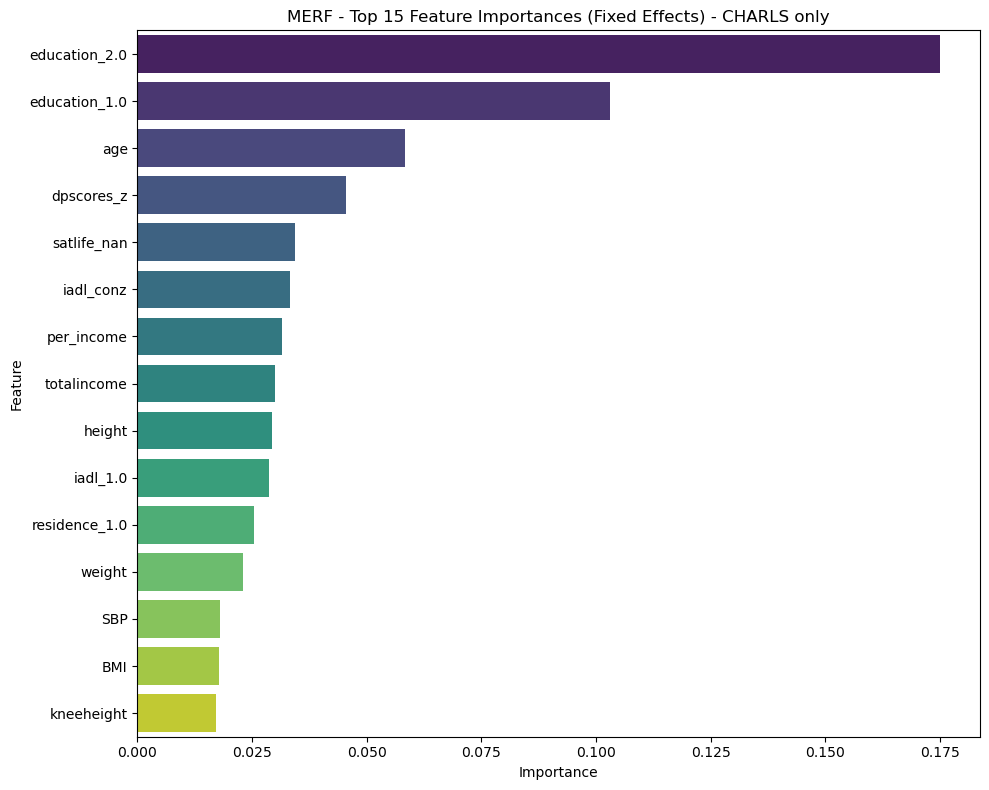


b. 随机效应 (Random Effects)
随机效应摘要:
count    20467.000000
mean        -0.047121
std          1.189182
min         -6.173264
25%         -0.791579
50%          0.037121
75%          0.743360
max          4.506391
Name: re, dtype: float64


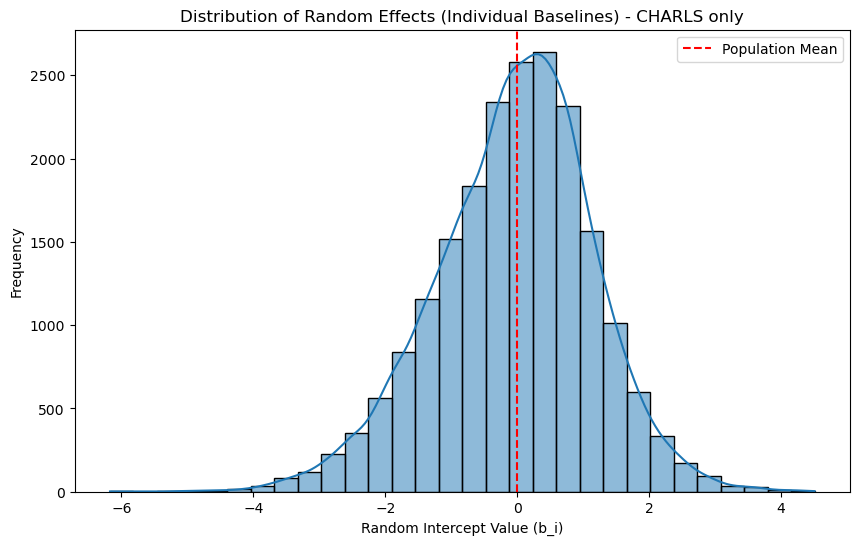


认知基线最高的5个个体:
                    re
ID                    
54249201002   4.506391
101791303001  4.438419
154044223002  4.280809
266059221002  4.232427
60440325002   4.214013

认知基线最低的5个个体:
                    re
ID                    
296331327001 -6.173264
18206316001  -5.161028
14643323001  -5.132920
330102312002 -4.965792
288251112002 -4.946933


In [17]:
# --- 7. 结果解读 ---
# a. 固定效应解读 (Feature Importances)
print("\na. 固定效应 (Feature Importances)")
fe_model = merf_model.fe_model
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': fe_model.feature_importances_
}).sort_values('importance', ascending=False)
print("最重要的15个固定效应特征:")
print(feature_importance.head(15))

plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importance.head(15), palette='viridis', hue='feature', legend=False)
plt.title('MERF - Top 15 Feature Importances (Fixed Effects) - CHARLS only')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# b. 随机效应解读 (Random Effects)
print("\nb. 随机效应 (Random Effects)")
random_effects_df = merf_model.trained_b.copy()
# 自动重命名第一列为 're'，确保后续代码兼容
first_col = random_effects_df.columns[0]
random_effects_df = random_effects_df.rename(columns={first_col: 're'})

print("随机效应摘要:")
print(random_effects_df['re'].describe())
plt.figure(figsize=(10, 6))
sns.histplot(random_effects_df['re'], kde=True, bins=30)
plt.title('Distribution of Random Effects (Individual Baselines) - CHARLS only')
plt.xlabel('Random Intercept Value (b_i)')
plt.ylabel('Frequency')
plt.axvline(0, color='red', linestyle='--', label='Population Mean')
plt.legend()
plt.show()
print("\n认知基线最高的5个个体:")
print(random_effects_df.sort_values('re', ascending=False).head(5))
print("\n认知基线最低的5个个体:")
print(random_effects_df.sort_values('re', ascending=True).head(5))